# Laying out a Mach-Zehnder Interferometer

This page will walk you through the steps of laying out an MZI for fabrication. In the last tutorial we learned how to use Simphony to simulate an MZI, and now we will learn to prepare a GDS file using the SiEPIC PDK. First we need to install the [ubcpdk package](https://gdsfactory.github.io/ubc/index.html). Following the installation instructions, we add it to our environment. 

```bash
conda install -c conda-forge gdstk -y
pip install ubcpdk --upgrade
```

Then we can play with the components. 

In [2]:
import gdsfactory as gf

import ubcpdk
import ubcpdk.components as uc

gf.CONF.display_type = "klayout"

2024-01-26 11:16:10.112 | INFO     | gdsfactory.technology.layer_views:__init__:790 - Importing LayerViews from YAML file: '/home/parkeraa/miniconda3/envs/mp/lib/python3.11/site-packages/ubcpdk/layers.yaml'.
2024-01-26 11:16:11.376 | INFO     | ubcpdk:<module>:30 - Found UBCpdk '2.3.4' installed at PosixPath('/home/parkeraa/miniconda3/envs/mp/lib/python3.11/site-packages/ubcpdk')
2024-01-26 11:16:11.456 | INFO     | gdsfactory.technology.layer_views:__init__:790 - Importing LayerViews from YAML file: '/home/parkeraa/miniconda3/envs/mp/lib/python3.11/site-packages/gdsfactory/generic_tech/layer_views.yaml'.
2024-01-26 11:16:11.461 | INFO     | gdsfactory.pdk:activate:307 - 'ubcpdk' PDK is now active


First, we can get a basic idea of what is going on by looking at a Y splitter. The code below creates the splitter, then plots it. pretty simple. The Y splitter is a fixed component in the PDK, which in this case means that it doesn't take any arguments and we can't change its geometry. All the components available in the PDK can be found in the [docs](https://gdsfactory.github.io/ubc/components.html).

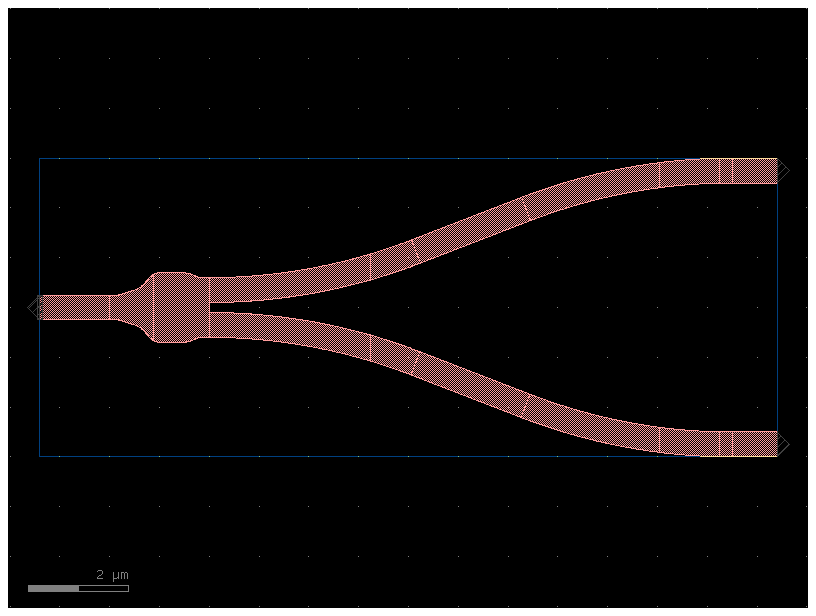

In [4]:
y = uc.ebeam_y_1550()
y.plot()

Now let's look at a component we can play with. We'll use a single-coupled ring. The ring has many features we can adjust, which are all listed in the [docs](https://gdsfactory.github.io/ubc/components_plot.html#ubcpdk.components.ring_single). For now we'll just play with the gap, the radius (of the bends), the length_x (which is the coupler length), and the length_y. Try a few of these values to try them out. 

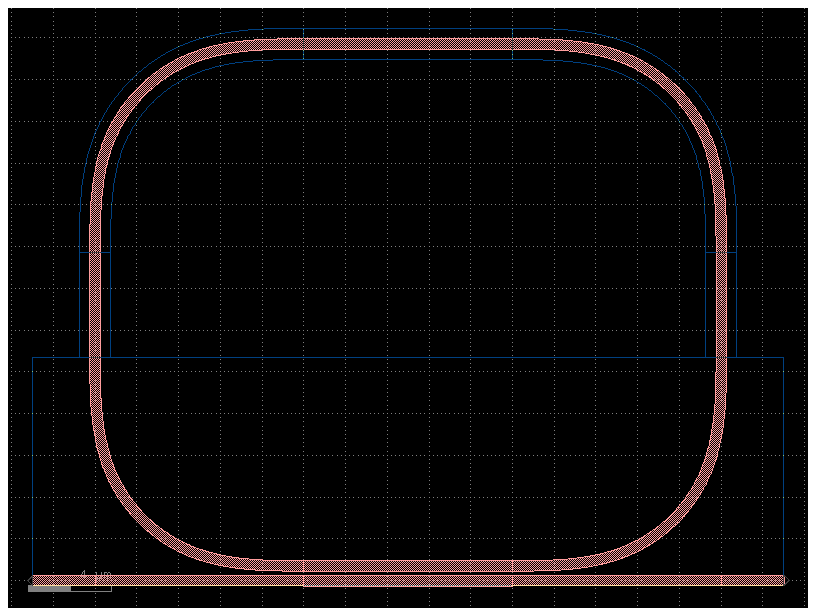

In [6]:
ring = uc.ring_single(gap=0.2, length_x=10, length_y=5, radius=10)
ring.plot()

Now let's make an MZI. First we will just see what the default parameters give us. 

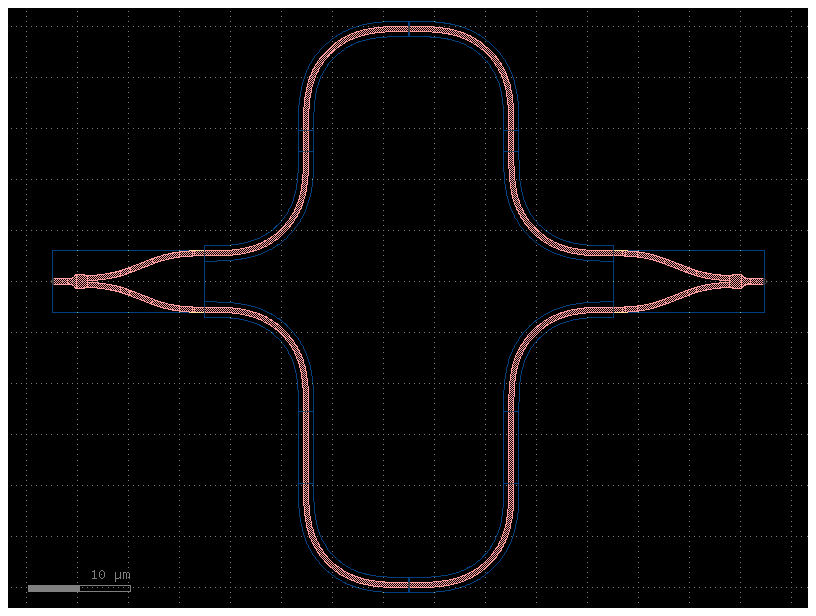

In [13]:
mzi = uc.mzi()
mzi.plot()

Now we can play around a little bit. First, we can change various lengths. We find the parameters in the [docs](https://gdsfactory.github.io/ubc/components_plot.html#ubcpdk.components.mzi). There is an ASCII drawing there that is helpful to understand what the different length parameters do.

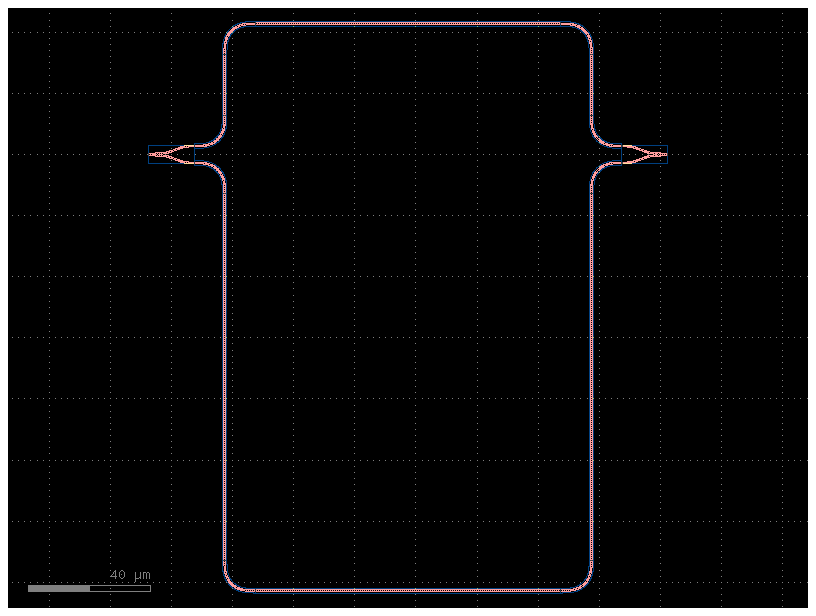

In [31]:
mzi = uc.mzi(delta_length=200, length_x=100, length_y=20)
mzi.plot()

Finally, we can easily add a grating array to any component. Note that the component we want to add gratings to will be rotated so that its ports are oriented vertically. Also, though we can't see it in the plot, adding the grating couplers also adds a label to one of the gratings, marking it as the input. 

:::Warning
The label is essential for the automated testing that is part of the OpenEBL fabrication run. The label tells the tester what polarization to use, which port is the input, and what to name the data set it collects. 
:::

We can set the device name on this label usig the 'name' argument. The [docs](https://gdsfactory.github.io/ubc/components_plot.html#ubcpdk.components.add_fiber_array) are always helpful.

MyName


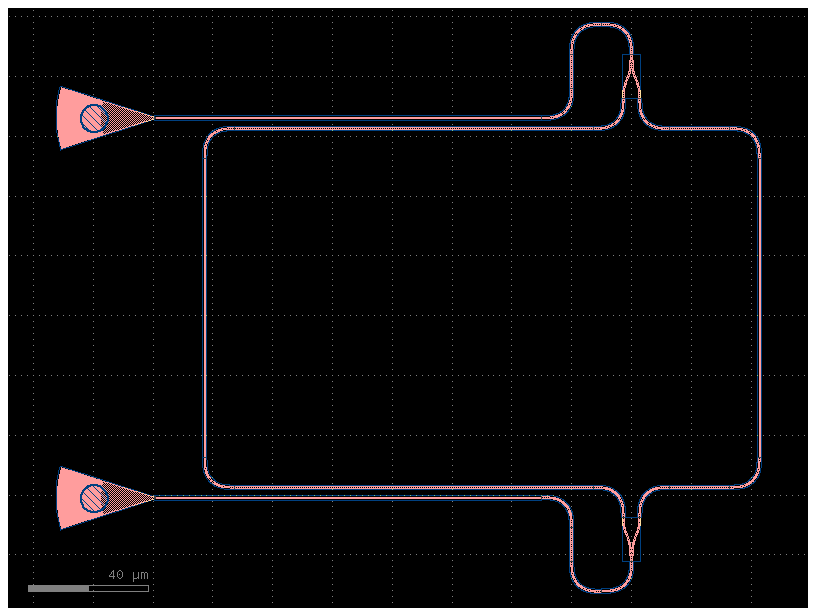

In [38]:
from ubcpdk.config import CONFIG

CONFIG.username='MyName'
print(CONFIG.username)
component_fiber_array = uc.add_fiber_array(component=mzi, name='My_cool_MZI')
component_fiber_array.plot()

We can export our design using the write_gds function. 

In [41]:
component_fiber_array.write_gds("mzi2.gds")

2024-01-26 12:37:27.910 | INFO     | gdsfactory.component:_write_library:1913 - Wrote to 'mzi2.gds'


PosixPath('mzi2.gds')